In [1]:
# coding: utf-8
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import cv2
from model import build_model
import matplotlib.pyplot as plt
import processing
from sklearn.metrics import mean_squared_error
import argparse
from model import build_model
import os
import pandas as pd
from pandas import Series
import pickle
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import keras.backend.tensorflow_backend as KTF
%matplotlib inline

Using TensorFlow backend.


In [2]:
if '__file__' not in globals():
    CURRENT_DIR = os.getcwd()
else:
    CURRENT_DIR = os.path.dirname(os.path.realpath(__file__))
SAVES = os.path.join(CURRENT_DIR, 'saves')
DATA_PATH =  os.path.join(CURRENT_DIR, 'data')
PREPARED_DATA_PATH = os.path.join(DATA_PATH, 'prepared-data')
FLOW_IMGS_TRAIN = os.path.join(PREPARED_DATA_PATH, 'flow_train_imgs')
TRAIN_FLOW_META_PATH = os.path.join(PREPARED_DATA_PATH, 'train_flow_meta.csv')
FLOW_IMGS_TEST = os.path.join(PREPARED_DATA_PATH, 'flow_test_imgs')
TEST_FLOW_META_PATH = os.path.join(PREPARED_DATA_PATH, 'test_flow_meta.csv')
TEST_META_PATH = os.path.join(PREPARED_DATA_PATH, 'test_meta.csv')
TEST_TEXT_PATH = os.path.join(DATA_PATH, 'test.txt')
SIZE = (100, 100)
CHANNEL = 2
WIDTH = SIZE[0]
HEIGHT = SIZE[1]

# Analysis

In [3]:
RUN = os.path.join(SAVES, '5', '100', '0.0005')
history = pickle.load(open(os.path.join(RUN, "history.p"), "rb" ))

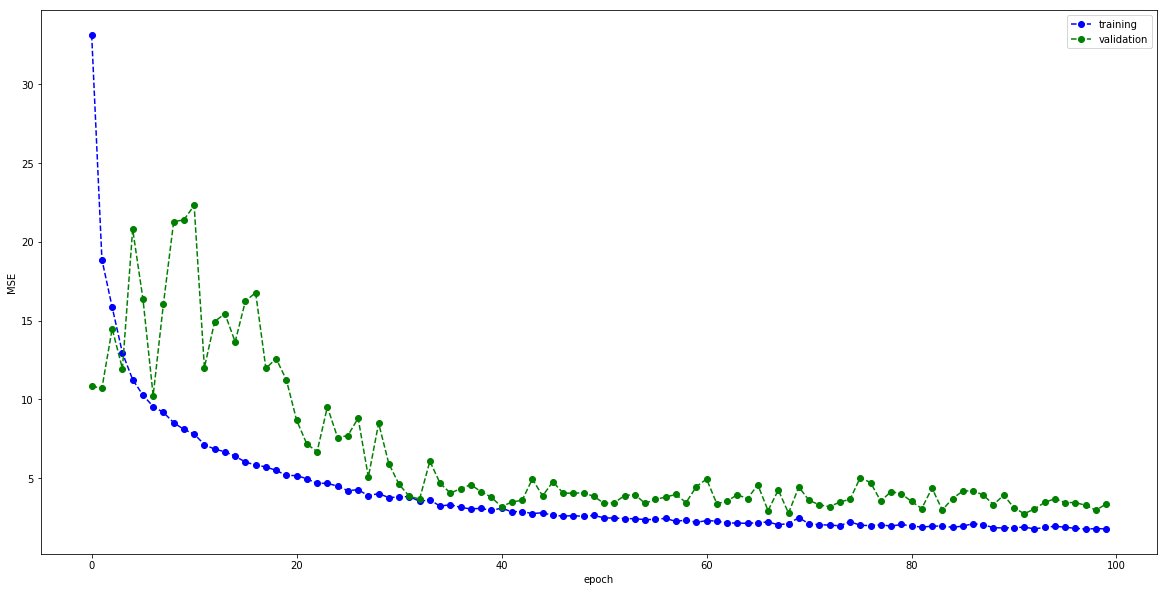

In [4]:
### plot the training and validation loss for each epoch
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history['loss'], 'bo--')
plt.plot(history['val_loss'], 'go--')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

In [5]:
weights = os.path.join(RUN, "weights.84-2.98.hdf5")
model = build_model(HEIGHT, WIDTH, CHANNEL, lr=0.0005)
model.load_weights(weights)

In [6]:
#Let's load the entire training video and evaluate the MSE on it
train_meta = pd.read_csv(TRAIN_FLOW_META_PATH)

In [7]:
train_meta.head()

,flow_path,speed
0,/home/ubuntu/repositories/speed-challenge/data...,28.105569
1,/home/ubuntu/repositories/speed-challenge/data...,28.106048
2,/home/ubuntu/repositories/speed-challenge/data...,28.118466
3,/home/ubuntu/repositories/speed-challenge/data...,28.119823
4,/home/ubuntu/repositories/speed-challenge/data...,28.098907


In [8]:
def predict(frame):
    for idx in tqdm(range(0, len(frame))):
        row = frame.iloc[[idx]].reset_index()
        flow = cv2.imread(row['flow_path'].values[0])
        flow = cv2.resize(flow, SIZE, interpolation=cv2.INTER_AREA)
        #drop useless channel
        flow = flow[:,:,[0,2]]
        #normalize
        flow = flow / 40
        speed = model.predict(np.array([flow]))
        frame.loc[[idx], 'predicted_speed'] = speed[0]

In [ ]:
predict(train_meta)

 91%|█████████ | 18578/20399 [01:19<00:07, 234.56it/s]

In [ ]:
train_meta.head()

In [ ]:
train_meta["predicted_speed"].min()

In [ ]:
#Clip the speed
train_meta.loc[train_meta["predicted_speed"] < 0] = 0

In [ ]:
train_meta.tail()

In [ ]:
train_meta.plot()

In [ ]:
#rolling window
window_size = 30
train_meta['averaged_predicted_speed'] = pd.rolling_median(train_meta['predicted_speed'], window_size, center=True, min_periods=1)

In [ ]:
train_meta.head()

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(np.arange(len(train_meta)), 
         train_meta[['predicted_speed']], 'bx')
plt.plot(np.arange(len(train_meta)), 
         train_meta[['speed']], 'go')
plt.plot(np.arange(len(train_meta)), 
         train_meta[['averaged_predicted_speed']], 'r')
plt.xlabel('frame')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['predicted speed', 'speed', 'averaged predicted speed'], loc='upper right')
plt.show()
plt.close()

In [ ]:
print(mean_squared_error(train_meta.iloc[1:-1, 1], 
                         train_meta.iloc[1:-1, 2]))

In [ ]:
print(mean_squared_error(train_meta.iloc[1:-1, 1], 
                         train_meta.iloc[1:-1, 3]))

# Prediction

In [ ]:
test_meta = pd.read_csv(TEST_FLOW_META_PATH)

In [ ]:
test_meta.head()

In [ ]:
predict(test_meta)

In [ ]:
test_meta.head()

In [ ]:
test_meta["predicted_speed"].min()

In [ ]:
#Clip the speed
test_meta.loc[test_meta["predicted_speed"] < 0] = 0

In [ ]:
#rolling window
window_size = 30
test_meta['averaged_predicted_speed'] = pd.rolling_median(test_meta['predicted_speed'], window_size, center=True, min_periods=1)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(np.arange(len(test_meta)), 
         test_meta[['predicted_speed']], 'bx')
plt.plot(np.arange(len(test_meta)), 
         test_meta[['averaged_predicted_speed']], 'r')
plt.xlabel('frame')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['predicted speed', 'averaged predicted speed'], loc='upper right')
plt.show()
plt.close()

In [ ]:
cv2.VideoWriter_fourcc(*'MJPG')
rec = cv2.VideoWriter('flow.avi',cv2.VideoWriter_fourcc(*'MJPG'),20,(300,300))
test_raw_meta = pd.read_csv(TEST_META_PATH)


In [ ]:
len(test_raw_meta)

In [ ]:
len(test_meta)
test_meta.head()

In [ ]:
#Add one more row to test_meta by copying the last row
last_speed = test_meta.iloc[[len(test_meta) - 1]]["averaged_predicted_speed"].values[0]
test_meta_extended = test_meta.append([{'averaged_predicted_speed': last_speed}], ignore_index=True)

In [ ]:
print(len(test_meta_extended))
test_meta_extended.tail()

In [ ]:
#Write the result on disk
test_meta_extended.to_csv(TEST_TEXT_PATH, columns = ["averaged_predicted_speed"], index=False, header=False)

# Video with a prediction overlay

In [ ]:
test_raw_meta.head()

In [ ]:
for index, row in tqdm(test_raw_meta.iterrows()):
    frame = cv2.imread(row["frame_path"])
    frame = cv2.resize(frame, (300, 300), interpolation=cv2.INTER_AREA)
    try:
        speed = test_meta.iloc[[index]]['smooth_predicted_speed'].values[0]
    except IndexError:
        speed = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame,"Predicted Speed: " + str(speed),(5,15),font, 0.55,(255,255,255),2)
    rec.write(frame)
rec.release()